### 1. Подготовка данных (Разделение: train.PurchDate < valid.PurchDate < test.PurchDate | Нормализация и преобразование)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score, auc, precision_recall_curve
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
import catboost as cb
import lightgbm as lgb
import xgboost as xgb

In [2]:
df = pd.read_csv('data/training.csv', index_col=0, parse_dates=['PurchDate'])
df.head()

,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,Color,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
RefId,,,,,,,,,,,,,,,,,,,,,
1,0,2009-12-07,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,RED,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
2,0,2009-12-07,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,WHITE,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
3,0,2009-12-07,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,MAROON,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
4,0,2009-12-07,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,SILVER,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
5,0,2009-12-07,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,SILVER,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72983 entries, 1 to 73014
Data columns (total 33 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   IsBadBuy                           72983 non-null  int64         
 1   PurchDate                          72983 non-null  datetime64[ns]
 2   Auction                            72983 non-null  object        
 3   VehYear                            72983 non-null  int64         
 4   VehicleAge                         72983 non-null  int64         
 5   Make                               72983 non-null  object        
 6   Model                              72983 non-null  object        
 7   Trim                               70623 non-null  object        
 8   SubModel                           72975 non-null  object        
 9   Color                              72975 non-null  object        
 10  Transmission                       7297

In [4]:
X = df.drop('IsBadBuy', axis=1)
y = df['IsBadBuy']

In [5]:
numeric_features = X.select_dtypes(include=['number'])
categorical_features = X.select_dtypes(include=['object'])

print(f'Count numeric: {len(numeric_features.columns.tolist())}')
print('Numeric features:', numeric_features.columns.tolist())
print(f'Count category: {len(categorical_features.columns.tolist())}')
print('Categorical features:', categorical_features.columns.tolist())

Count numeric: 17
Numeric features: ['VehYear', 'VehicleAge', 'WheelTypeID', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'BYRNO', 'VNZIP1', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']
Count category: 14
Categorical features: ['Auction', 'Make', 'Model', 'Trim', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART', 'VNST']


In [6]:
def split_df(df_split):
    sort_df = df_split.sort_values(by='PurchDate', ascending=True)

    train_end = int(len(sort_df) * 0.33)
    valid_end = int(len(sort_df) * 0.66)

    X = sort_df.drop('IsBadBuy', axis=1)
    y = sort_df['IsBadBuy']

    X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
    X_valid, y_valid = X.iloc[train_end:valid_end], y.iloc[train_end:valid_end]
    X_test, y_test = X.iloc[valid_end:], y.iloc[valid_end:]

    print(sort_df.shape)

    return X_train, X_valid, X_test, y_train, y_valid, y_test


X_train, X_valid, X_test, y_train, y_valid, y_test = split_df(df)

print(X_train.iloc[:3, :3], y_train.iloc[:3], X_valid.iloc[:3, :3], y_valid.iloc[:3], X_test.iloc[:3, :3],
      y_test.iloc[:3], sep='\n\n')

(72983, 33)
       PurchDate  Auction  VehYear
RefId                             
32389 2009-01-05  MANHEIM     2007
32406 2009-01-05  MANHEIM     2005
32407 2009-01-05  MANHEIM     2004

RefId
32389    0
32406    0
32407    0
Name: IsBadBuy, dtype: int64

       PurchDate  Auction  VehYear
RefId                             
44690 2009-09-11    OTHER     2007
44697 2009-09-11    OTHER     2006
5567  2009-09-11  MANHEIM     2004

RefId
44690    0
44697    0
5567     0
Name: IsBadBuy, dtype: int64

       PurchDate  Auction  VehYear
RefId                             
37502 2010-05-11  MANHEIM     2004
37501 2010-05-11  MANHEIM     2006
63599 2010-05-11  MANHEIM     2004

RefId
37502    0
37501    0
63599    0
Name: IsBadBuy, dtype: int64


In [7]:
def check_split_for_date(X_train, X_valid, X_test):
    print('Train:')
    print(X_train['PurchDate'].min())
    print(X_train['PurchDate'].max())

    print('Valid:')
    print(X_valid['PurchDate'].min())
    print(X_valid['PurchDate'].max())

    print('Test:')
    print(X_test['PurchDate'].min())
    print(X_test['PurchDate'].max())


check_split_for_date(X_train, X_valid, X_test)

Train:
2009-01-05 00:00:00
2009-09-11 00:00:00
Valid:
2009-09-11 00:00:00
2010-05-11 00:00:00
Test:
2010-05-11 00:00:00
2010-12-30 00:00:00


In [8]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

ohe = OneHotEncoder(categories='auto', handle_unknown='ignore')

X_train_test_ohe = ohe.fit_transform(X_train[categorical_features])
X_valid_test_ohe = ohe.transform(X_valid[categorical_features])
X_test_test_ohe = ohe.transform(X_test[categorical_features])

print(X_train_test_ohe.shape)
unique_features = X_train[categorical_features].nunique().sum()
unique_features_is_null = (X_train[categorical_features].isnull().sum() > 0).sum()
print(f'Unique features -> category columns: {unique_features + unique_features_is_null}')

(24084, 1695)
Unique features -> category columns: 1695


In [9]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

mms = MinMaxScaler()

X_train_test_mms = mms.fit_transform(X_train[numerical_features])
X_valid_test_mms = mms.transform(X_valid[numerical_features])
X_test_test_mms = mms.transform(X_test[numerical_features])

print(X_train_test_mms.shape)
print(f'Numeric columns: {len(X_train[numerical_features].columns)}')

(24084, 17)
Numeric columns: 17


In [10]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# ColumnTransformer - Совмещенный подход :)

# 1. Заполняем пропуски
preprocessor_fill = ColumnTransformer(
    transformers=[
        ('fill_null_category', SimpleImputer(strategy='constant', fill_value='missing'), categorical_features),
        ('fill_null_numeric', KNNImputer(n_neighbors=2, weights="uniform"), numerical_features),
    ]
)

X_train_filled = preprocessor_fill.fit_transform(X_train)
X_valid_filled = preprocessor_fill.transform(X_valid)
X_test_filled = preprocessor_fill.transform(X_test)

# 2. Кодируем категории и нормализуем числа
preprocessor_encoder = ColumnTransformer(
    transformers=[
        ('category', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features),
        # Применяем OneHotEncoder к категориальным столбцам
        ('numeric', MinMaxScaler(), numerical_features)  # Применяем StandardScaler к числовым столбцам
    ]
)

X_train_filled = pd.DataFrame(X_train_filled, columns=categorical_features + numerical_features)
X_valid_filled = pd.DataFrame(X_valid_filled, columns=categorical_features + numerical_features)
X_test_filled = pd.DataFrame(X_test_filled, columns=categorical_features + numerical_features)

X_train_transform = preprocessor_encoder.fit_transform(X_train_filled)
X_valid_transform = preprocessor_encoder.transform(X_valid_filled)
X_test_transform = preprocessor_encoder.transform(X_test_filled)

print(X_train_transform.shape)
print(X_train_transform)
# print(pd.DataFrame(X_train_transform).isnull().sum().sum())

(24084, 1712)
[[0.         1.         0.         ... 0.14887393 0.         0.13175099]
 [0.         1.         0.         ... 0.1354579  0.         0.06807845]
 [0.         1.         0.         ... 0.09345034 0.         0.09849346]
 ...
 [0.         0.         1.         ... 0.08795197 0.         0.08399659]
 [0.         0.         1.         ... 0.2419064  0.         0.07404775]
 [0.         0.         1.         ... 0.1253409  0.         0.28894258]]


### 2. Реализация DecisionTreeClassifier и DecisionTreeRegressor

In [88]:
class Node:
    def __init__(self, depth, is_leaf=False, prediction=None, class_counts=None):
        self.depth = depth # Глубина узла
        self.is_leaf = is_leaf # Узел == лист?
        self.prediction = prediction # Предсказание для узла
        self.left = None # Левый потомок
        self.right = None # Правый потомок
        self.feature = None # Признак для разделения
        self.value = None # Значение для разделения
        self.class_counts = class_counts

class MyDecisionTreeClassifier:
    def __init__(self, max_depth=10, random_split=False, skip_more_features=False):
        self.max_depth = max_depth # Максимальная глубина дерева
        self.random_split = random_split # Случайное разбиение?
        self.root = None # Корень дерева
        self.skip_more_features = skip_more_features

    def fit(self, X, y):
        self.root = self._tree(X, y, depth=0)

    def _tree(self, X, y, depth):

        # Предсказание - самый частый класс
        default_prediction = Counter(y).most_common(1)[0][0] if len(y) > 0 else 0
        class_counts = np.bincount(y, minlength=2) if len(y) > 0 else np.array([0, 0])  # Считаем частоты классов

        # Если достигнута максимальная глубина - создаем листовой узел
        if depth >= self.max_depth:
            return Node(depth, is_leaf=True, prediction=default_prediction, class_counts=class_counts)

        # Разбиение по gini или случайное -> Признак для разбивки и значение
        if self.random_split:
            feature, value = self._random_split(X, y)
        else:
            feature, value = self._split(X, y)

        # Если не удалось -> создаем лист
        if feature is None:
            return Node(depth, is_leaf=True, prediction=default_prediction, class_counts=class_counts)

        # Индексы для выборок по порогу
        left_index = X[:, feature] <= value
        right_index = X[:, feature] > value

        # Рекурсивное построение поддеревьев
        left_child = self._tree(X[left_index], y[left_index], depth + 1)
        right_child = self._tree(X[right_index], y[right_index], depth + 1)

        # Создание внутреннего узла для связи с поддеревьями
        node = Node(depth)
        node.feature = feature
        node.value = value
        node.left = left_child
        node.right = right_child
        node.class_counts = class_counts

        return node

    def _split(self, X, y):

        n_features = X.shape[1]
        best_gini = 1.0
        best_split = None
        # Проходимся по всем признакам
        for feature in range(n_features): # 2^max_depth
            values = np.unique(X[:, feature])  # Уникальные значения для признака
            
            if self.skip_more_features:
                if len(values) > 10: # Для быстрого вычисления 
                    continue # Пропускаем признаки с множественными уникальными значениями 
            
            for value in values: # Для каждого уникального значения
                # Берем индексы по значению
                left_index = X[:, feature] <= value
                right_index = X[:, feature] > value
                
                if len(y[left_index]) == 0 or len(y[right_index]) == 0:
                    continue
                    
                # Вычисление gini 
                left_gini = self._gini(y[left_index])
                right_gini = self._gini(y[right_index])
                
                # Общий gini
                gini_split = (len(y[left_index]) * left_gini + len(y[right_index]) * right_gini) / len(y)
            
                # Обновление лучшего разбиения
                if gini_split < best_gini:
                    best_gini = gini_split
                    best_split = (feature, value)

        return best_split if best_split else (None, None)

    def _random_split(self, X, y):
        
        n_features = X.shape[1]
        feature = np.random.randint(0, n_features) # Случайный признак
        values = np.unique(X[:, feature]) # Уникальные значения
        if len(values) == 0:
            return None, None
        value = np.random.choice(values) # Случайное значение
        return feature, value

    def _gini(self, y): # Расчет gini 
        if len(y) == 0:
            return 0
        counts = np.bincount(y)
        prob = counts / len(y)
        return 1 - np.sum(prob ** 2)

    def predict(self, X):
        return np.array([self._predict_tree(x, self.root) for x in X])

    def _predict_tree(self, x, node):
        if node.is_leaf:
            return node.prediction
        return self._predict_tree(x, node.left if x[node.feature] <= node.value else node.right)

    def predict_proba(self, X):
        return np.array([self._proba_tree(x, self.root) for x in X]) # Warning np.array


    def _proba_tree(self, x, node):
        if node.is_leaf:
            total = node.class_counts.sum()
            if total == 0:
                return np.array([0.5, 0.5])  # или [1.0, 0.0] — на твой выбор
            return node.class_counts / total
        return self._proba_tree(x, node.left if x[node.feature] <= node.value else node.right)
    
        
class MyDecisionTreeRegressor(MyDecisionTreeClassifier):
    def _split(self, X, y):

        n_features = X.shape[1]
        best_split = None
        best_mse = float('inf')
        # Проходимся по всем признакам
        for feature in range(n_features): # 2^max_depth
            values = np.unique(X[:, feature])  # Уникальные значения для признака
            
            if self.skip_more_features:
                if len(values) > 10: # Для быстрого вычисления 
                    continue # Пропускаем признаки с множественными уникальными значениями 
            
            for value in values: # Для каждого уникального значения
                # Берем индексы по значению
                left_index = X[:, feature] <= value
                right_index = X[:, feature] > value
                
                if len(y[left_index]) == 0 or len(y[right_index]) == 0:
                    continue
                
                # Вычисление MSE
                left_mse = self._mse(y[left_index])
                right_mse = self._mse(y[right_index])
                # Общий MSE
                mse_split = (len(y[left_index]) * left_mse + len(y[right_index]) * right_mse) / len(y)
            
                # Обновление лучшего разбиения
                if mse_split < best_mse:
                    best_mse = mse_split
                    best_split = (feature, value)
    
        return best_split if best_split else (None, None)
    
    def _mse(self, y): # Расчет MSE
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

In [12]:
model_random = MyDecisionTreeClassifier(max_depth=10, random_split=True)
model_random.fit(X_train_transform, y_train)
y_pred_random = model_random.predict(X_valid_transform)
y_proba_random = model_random.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_random, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     20926
           1       0.00      0.00      0.00      3158

    accuracy                           0.87     24084
   macro avg       0.43      0.50      0.46     24084
weighted avg       0.75      0.87      0.81     24084



In [13]:
model_classifier = MyDecisionTreeClassifier(max_depth=4, random_split=False)
model_classifier.fit(X_train_transform, y_train)
y_pred_classifier = model_classifier.predict(X_valid_transform)
y_proba_classifier = model_classifier.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_classifier, zero_division=0))

100%|██████████| 1712/1712 [00:00<00:00, 3995.00it/s]

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     20926
           1       0.79      0.24      0.37      3158

    accuracy                           0.89     24084
   macro avg       0.84      0.62      0.66     24084
weighted avg       0.88      0.89      0.87     24084



In [ ]:
model_regressor = MyDecisionTreeRegressor(max_depth=4, random_split=False)
model_regressor.fit(X_train_transform, y_train)
y_pred_regressor = model_regressor.predict(X_valid_transform)
y_proba_regressor = model_regressor.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_regressor, zero_division=0))

### 3. Коэффициент Gini

In [17]:
def gini_graph(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    gini = 2 * auc - 1
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    plt.figure(figsize=(15, 8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, color='g', label=f'AUC = {auc:.2f} (Gini = {gini:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.legend(loc='lower right')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate') 

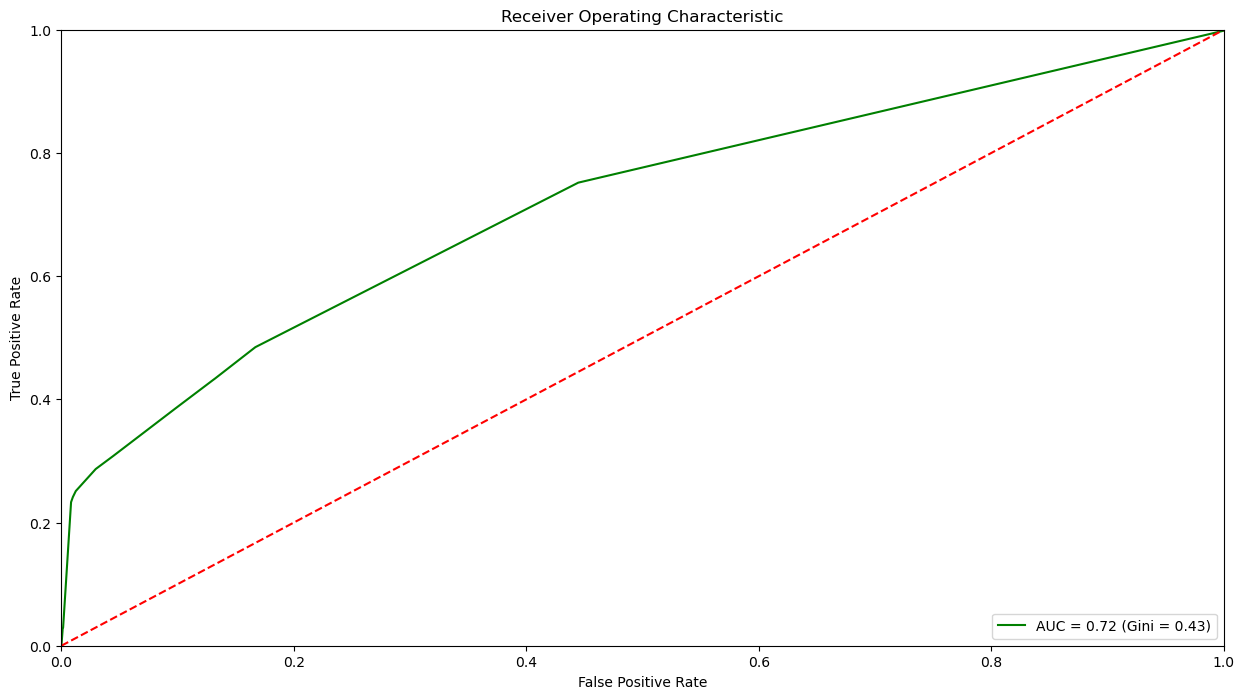

In [16]:
gini_graph(y_valid, np.array(y_proba_classifier)[:, 1])

### 4. DecisionTreeClassifier (sklearn)

In [17]:
dtc = DecisionTreeClassifier(max_depth=4, splitter='best')
dtc.fit(X_train_transform, y_train)
y_pred_dtc = dtc.predict(X_valid_transform)
y_proba_dtc = dtc.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_dtc))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94     20926
           1       0.79      0.24      0.37      3158

    accuracy                           0.89     24084
   macro avg       0.84      0.62      0.66     24084
weighted avg       0.88      0.89      0.87     24084



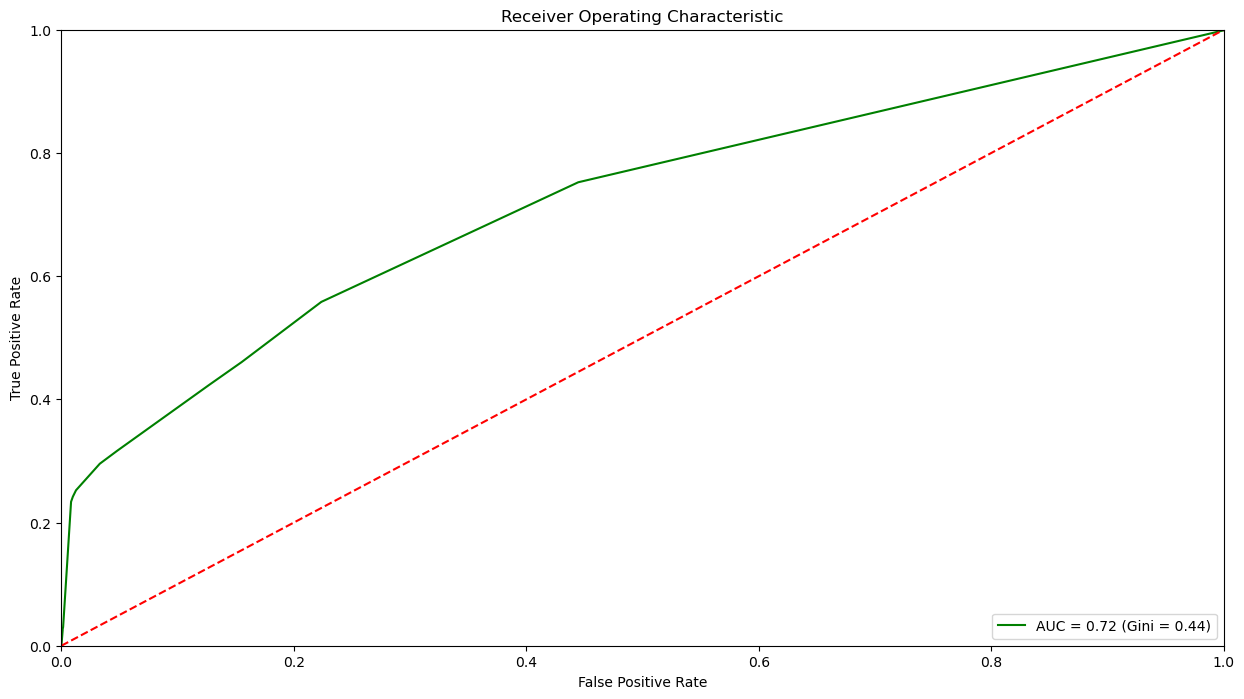

In [18]:
gini_graph(y_valid, y_proba_dtc[:, 1])

### 5. Реализация RandomForestClassifier

In [19]:
class MyRandomForestClassifier:
    def __init__(self, n_estimators=2, max_depth=4):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        self.trees = []
        
        if type(y) != np.ndarray:
            y = np.array(y)
        
        for _ in range(self.n_estimators):
            
            print('Estimator:', _ + 1)
            indices = np.random.choice(len(X), size=len(X))
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            tree = MyDecisionTreeClassifier(max_depth=self.max_depth, skip_more_features=True)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_predictions.T]
    
    def predict_proba(self, X):
        tree_probs = np.array([tree.predict_proba(X) for tree in self.trees])
        return np.mean(tree_probs, axis=0)

In [20]:
model_forest = MyRandomForestClassifier(n_estimators=2, max_depth=4)
model_forest.fit(X_train_transform, y_train)
y_pred_forest = model_forest.predict(X_valid_transform)
y_proba_forest = model_forest.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_forest))

Estimator: 1


100%|██████████| 1712/1712 [00:00<00:00, 36532.33it/s]


Estimator: 2


100%|██████████| 1712/1712 [00:00<00:00, 49124.31it/s]


              precision    recall  f1-score   support

           0       0.89      0.99      0.94     20926
           1       0.81      0.23      0.36      3158

    accuracy                           0.89     24084
   macro avg       0.85      0.61      0.65     24084
weighted avg       0.88      0.89      0.86     24084



In [21]:
tree = MyDecisionTreeClassifier(max_depth=4, skip_more_features=True)
tree.fit(X_train_transform, y_train)
y_pred_tree = tree.predict(X_valid_transform)
y_proba_tree = tree.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_tree))

100%|██████████| 1712/1712 [00:00<00:00, 10018.46it/s]


              precision    recall  f1-score   support

           0       0.89      0.99      0.94     20926
           1       0.78      0.23      0.35      3158

    accuracy                           0.89     24084
   macro avg       0.84      0.61      0.65     24084
weighted avg       0.88      0.89      0.86     24084



Text(0.5, 1.0, 'Decision Tree')

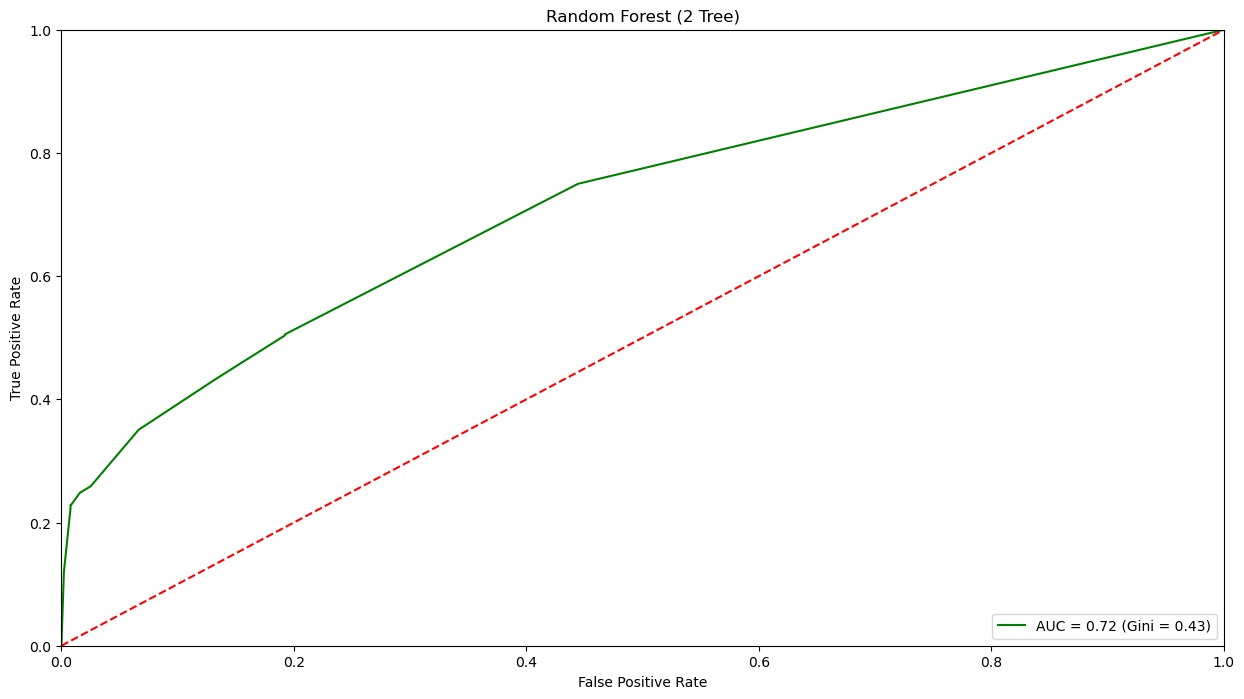

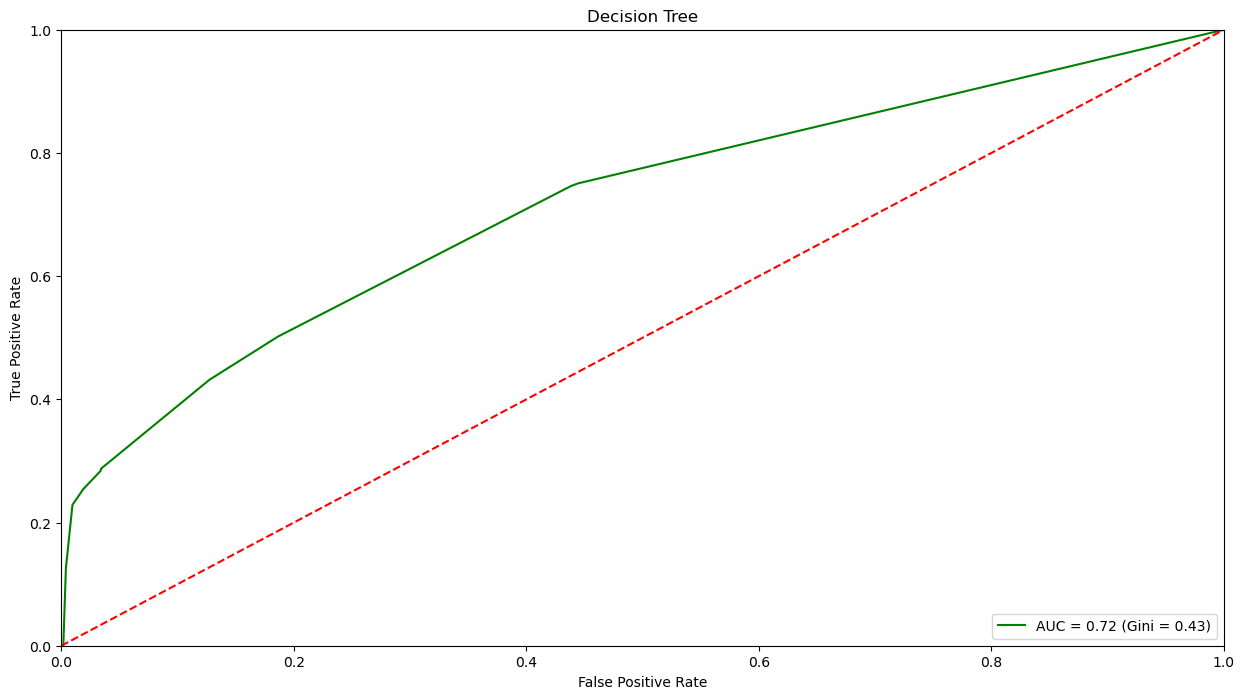

In [22]:
gini_graph(y_valid, y_proba_forest[:, 1])
plt.title('Random Forest (2 Tree)')
gini_graph(y_valid, y_proba_tree[:, 1])
plt.title('Decision Tree')

### 6. Реализация GradientBoostingDecisionTreeClassifier (GDBT)

In [65]:
import numpy as np
from scipy.special import expit  # Сигмоида

class GradientBoostingClassifier:
    def __init__(self, max_depth=4, number_of_trees=10, max_features=None, learning_rate=0.1, skip_more_features=False):
        self.max_depth = max_depth
        self.number_of_trees = number_of_trees
        self.max_features = max_features
        self.learning_rate = learning_rate
        self.skip_more_features = skip_more_features
        self.trees = []
        self.init_log_odds = None

    def _log_odds(self, p):
        eps = 1e-15
        p = np.clip(p, eps, 1 - eps)
        return np.log(p / (1 - p))

    def fit(self, X, y):
        # 1. Начальная логит-оценка (по базовому вероятностному предположению)
        pos_ratio = np.mean(y)  # Средняя вероятность "1"
        self.init_log_odds = self._log_odds(pos_ratio)
        pred = np.full(len(y), self.init_log_odds)

        for _ in range(self.number_of_trees):
            # 2. Вычисляем градиенты (производная по логитам)
            probas = expit(pred)  # Сигмоида
            gradients = y - probas  # Производная бинарной кросс-энтропии

            # 3. Обучаем дерево на градиентах
            tree = MyDecisionTreeRegressor(max_depth=self.max_depth, skip_more_features=self.skip_more_features)
            tree.fit(X, gradients)

            # 4. Предсказание дерева и обновление логитов
            update = tree.predict(X)
            pred += self.learning_rate * update

            # 5. Сохраняем дерево
            self.trees.append(tree)

    def predict_proba(self, X):
        pred = np.full(X.shape[0], self.init_log_odds)
        for tree in self.trees:
            pred += self.learning_rate * tree.predict(X)
        probas = expit(pred)  # Преобразуем логиты в вероятности
        return np.vstack([1 - probas, probas]).T

    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba[:, 1] >= 0.5).astype(int)


In [66]:
gdbt = GradientBoostingClassifier(max_depth=4, number_of_trees=4, learning_rate=0.1, skip_more_features=True)
gdbt.fit(X_train_transform, y_train)
y_pred_gdbt = gdbt.predict(X_valid_transform)
y_proba_gdbt = gdbt.predict_proba(X_valid_transform)
print(classification_report(y_valid, y_pred_gdbt, zero_division=0))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93     20926
           1       0.00      0.00      0.00      3158

    accuracy                           0.87     24084
   macro avg       0.43      0.50      0.46     24084
weighted avg       0.75      0.87      0.81     24084



### 7. LightGBM, Catboost и XGBoost

## Сравнение алгоритмов градиентного бустинга

| Алгоритм   | Описание | Плюсы | Минусы |
|------------|----------|-------|--------|
| **LightGBM** | Градиентный бустинг, использующий метод разбиения на основе гистограммы и Leaf-wise стратегию для ускорения обучения. | - Очень быстрый, особенно на больших данных. <br> - Поддержка категориальных признаков. <br> - Хорошая масштабируемость. | - Очень чувствителен к дисбалансу классов. <br> - Могут быть проблемы с точностью на небольших данных. |
| **CatBoost** | Библиотека, разработанная для обработки категориальных признаков без необходимости их предварительного кодирования. Использует ordered boosting для борьбы с переобучением. | - Автоматически обрабатывает категориальные признаки. <br> - Устойчива к переобучению. <br> - Высокая точность на табличных данных. | - Более медленное обучение по сравнению с LightGBM. <br> - Меньше гибкости в настройках, чем у XGBoost. |
| **XGBoost** | Один из самых популярных инструментов для градиентного бустинга, поддерживает различные методы регуляризации и оптимизации, включая DART. | - Очень гибкий, множество гиперпараметров. <br> - Хорошо справляется с несбалансированными данными. <br> - Поддерживает DART для борьбы с переобучением. | - Не поддерживает категориальные признаки напрямую (нужен one-hot encoding). <br> - Занимает больше времени для обучения, чем LightGBM. |


In [12]:
import warnings
warnings.filterwarnings('ignore')

def evaluate_models(models_list):
    for model in models_list:
        print(f"\nModel: {model.__class__.__name__}")
        model.fit(X_train_transform, y_train)
        y_pred_model = model.predict(X_valid_transform)
        print(classification_report(y_valid, y_pred_model))
    
models = [lgb.LGBMClassifier(verbose=0), cb.CatBoostClassifier(verbose=0), xgb.XGBClassifier()]
evaluate_models(models)


Model: LGBMClassifier
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     20926
           1       0.79      0.23      0.36      3158

    accuracy                           0.89     24084
   macro avg       0.84      0.61      0.65     24084
weighted avg       0.88      0.89      0.86     24084


Model: CatBoostClassifier
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     20926
           1       0.79      0.24      0.37      3158

    accuracy                           0.89     24084
   macro avg       0.84      0.61      0.65     24084
weighted avg       0.88      0.89      0.87     24084


Model: XGBClassifier
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     20926
           1       0.75      0.24      0.36      3158

    accuracy                           0.89     24084
   macro avg       0.82      0.61      0.65     24084
we

### 8. Оптимизация лучшей модели

In [12]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'iterations': [100, 200, 500],
    'learning_rate': np.logspace(-3, 0, 10),
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7],
    'random_strength': [0.1, 0.5, 1],
    'border_count': [32, 64, 128]
}

model = cb.CatBoostClassifier(verbose=0, random_state=21)
clf = RandomizedSearchCV(estimator=model, param_distributions=params, random_state=21, n_jobs=-1)
search = clf.fit(X_train_transform, y_train)
print(f'{model.__class__.__name__}: {search.best_params_}')

CatBoostClassifier: {'random_strength': 0.1, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 100, 'depth': 4, 'border_count': 32}


In [19]:
cat = cb.CatBoostClassifier(**search.best_params_, verbose=0)
cat.fit(X_train_transform, y_train)

In [21]:
y_pred_train = cat.predict(X_train_transform)
y_pred_valid = cat.predict(X_valid_transform)
y_pred_test = cat.predict(X_test_transform)
print('Train:')
print(classification_report(y_train, y_pred_train))
print('Valid:')
print(classification_report(y_valid, y_pred_valid))
print('Test:')
print(classification_report(y_test, y_pred_test))

Train:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     21328
           1       0.84      0.23      0.36      2756

    accuracy                           0.91     24084
   macro avg       0.87      0.61      0.65     24084
weighted avg       0.90      0.91      0.88     24084

Valid:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     20926
           1       0.80      0.24      0.37      3158

    accuracy                           0.89     24084
   macro avg       0.85      0.61      0.65     24084
weighted avg       0.88      0.89      0.87     24084

Test:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     21753
           1       0.69      0.24      0.35      3062

    accuracy                           0.89     24815
   macro avg       0.80      0.61      0.65     24815
weighted avg       0.88      0.89      0.87     24815


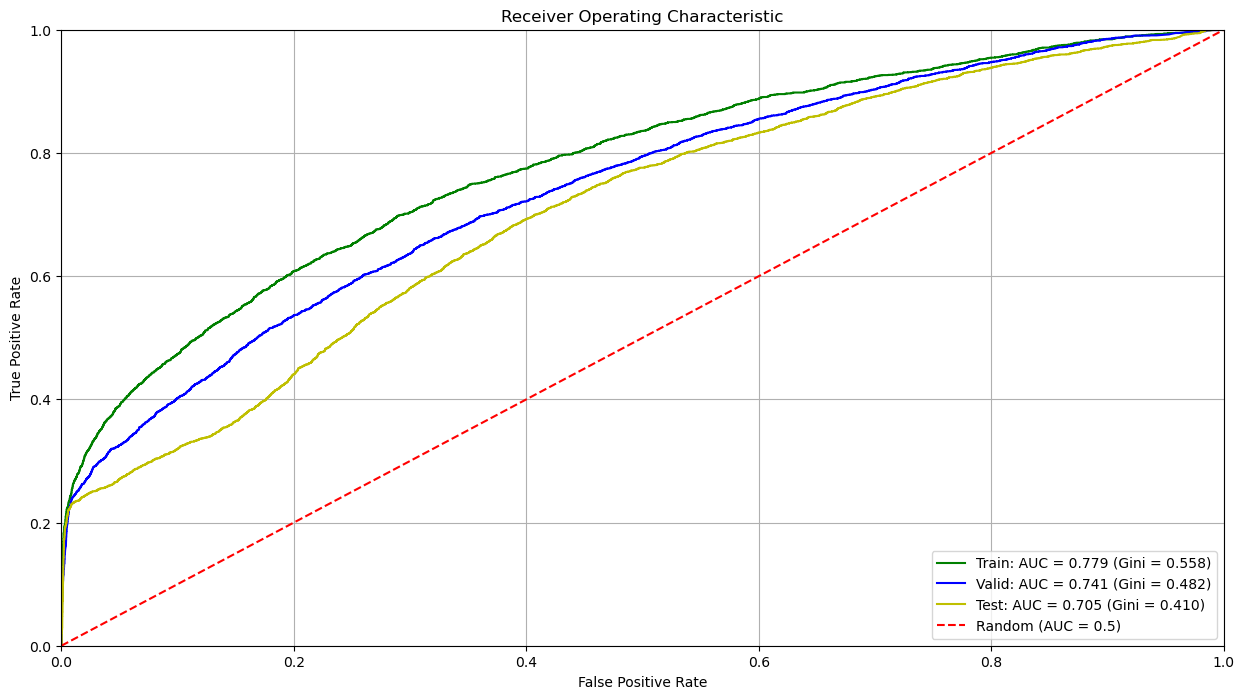

In [22]:
y_proba_train = cat.predict_proba(X_train_transform)[:, 1]
y_proba_valid = cat.predict_proba(X_valid_transform)[:, 1]
y_proba_test = cat.predict_proba(X_test_transform)[:, 1]

auc_train = roc_auc_score(y_train, y_proba_train)
gini_train = 2 * auc_train - 1
fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)

auc_valid = roc_auc_score(y_valid, y_proba_valid)
gini_valid = 2 * auc_valid - 1
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_proba_valid)

auc_test = roc_auc_score(y_test, y_proba_test)
gini_test = 2 * auc_test - 1
fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)

plt.figure(figsize=(15, 8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, color='g', 
         label=f'Train: AUC = {auc_train:.3f} (Gini = {gini_train:.3f})')
plt.plot(fpr_valid, tpr_valid, color='b', 
         label=f'Valid: AUC = {auc_valid:.3f} (Gini = {gini_valid:.3f})')
plt.plot(fpr_test, tpr_test, color='y', 
         label=f'Test: AUC = {auc_test:.3f} (Gini = {gini_test:.3f})')
plt.plot([0, 1], [0, 1], 'r--', label='Random (AUC = 0.5)')
plt.legend(loc='lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.grid(True)
plt.show()

### 9. Реализация ExtraTreesClassifier

In [107]:
class MyExtraTreesClassifier:
    def __init__(self, n_estimators=20, max_depth=14):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        self.trees = []
        
        if not isinstance(y, np.ndarray):
            y = np.array(y)
        
        class_counts = np.bincount(y)
        class_weights = {0: 1, 1: class_counts[0]/class_counts[1]} 
        # Рассчитываем веса для каждого образца в зависимости от его класса
        sample_weights = np.array([class_weights[label] for label in y])
        sample_weights = sample_weights / sample_weights.sum()  # нормализуем
        for _ in range(self.n_estimators):
            indices = np.random.choice(len(X), size=len(X), p=sample_weights)
            X_bootstrap = X[indices]
            y_bootstrap = y[indices]
            
            tree = MyDecisionTreeClassifier(max_depth=self.max_depth, random_split=True)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)
        
    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return [Counter(tree_pred).most_common(1)[0][0] for tree_pred in tree_predictions.T]
    
    def predict_proba(self, X):
        tree_probs = np.array([tree.predict_proba(X) for tree in self.trees])
        return np.mean(tree_probs, axis=0)

In [108]:
extra = MyExtraTreesClassifier()
extra.fit(X_train_transform, y_train)
y_pred_extra = extra.predict(X_valid_transform)
print(classification_report(y_valid, y_pred_extra))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91     20926
           1       0.22      0.08      0.12      3158

    accuracy                           0.84     24084
   macro avg       0.55      0.52      0.51     24084
weighted avg       0.79      0.84      0.81     24084



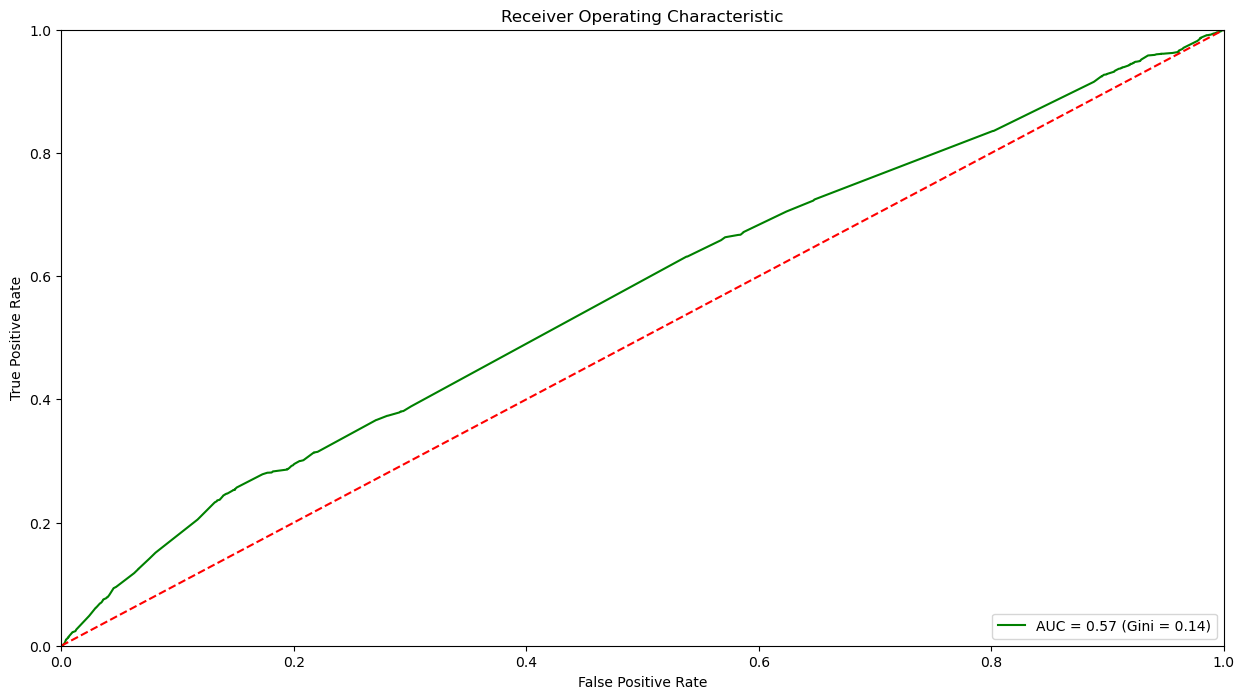

In [109]:
y_proba_extra = extra.predict_proba(X_valid_transform)[:, 1]
gini_graph(y_valid, y_proba_extra)